该文件用于Google colab上训练

In [1]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [ ]:
# !git clone https://github.com/Bozenton/Pytorch-UNet-on-DRIVE.git

Cloning into 'Pytorch-UNet-on-DRIVE'...
remote: Enumerating objects: 654, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 654 (delta 2), reused 16 (delta 1), pack-reused 635
Receiving objects: 100% (654/654), 75.59 MiB | 12.45 MiB/s, done.
Resolving deltas: 100% (278/278), done.
Checking out files: 100% (125/125), done.


In [2]:
%cd './Pytorch-UNet-on-DRIVE'

/content/drive/MyDrive/Pytorch-UNet-on-DRIVE


In [1]:
%pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import logging
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from utils.DriveDataset import DriveDataset
from unet import UNet
from utils.dice_score import dice_loss
from evaluate import evaluate

dir_img = Path('./datasets/training/images')
# train_label_dir = Path('./datasets/training/1st_manual')
dir_mask = Path('./datasets/training/1st_manual')
dir_checkpoint = Path('./checkpoints/')

wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anony-moose-262620. Use `wandb login --relogin` to force relogin


True

In [2]:

def train(net: UNet,
      device,
      epochs: int = 5,
      batch_size: int = 1,
      learning_rate: float = 1e-5,
      val_percent: float = 0.1,
      save_checkpoint: bool = True,
      img_scale: float = 0.5,
      amp: bool = False):
  dataset = DriveDataset(dir_img, dir_mask, img_scale, mask_suffix='_manual1')

  n_val = int(len(dataset) * val_percent)
  n_train = len(dataset) - n_val
  train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

  loader_args = dict(batch_size=batch_size, num_workers=2, pin_memory=True)
  train_loader = DataLoader(train_set, shuffle=True, **loader_args)
  val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

  experiment = wandb.init(project='UNetDRIVE', resume='allow', anonymous='must')
  experiment.config.update(dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
                                val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale,
                                amp=amp))
  logging.info(f'''Starting training:
      Epochs:          {epochs}
      Batch size:      {batch_size}
      Learning rate:   {learning_rate}
      Training size:   {n_train}
      Validation size: {n_val}
      Checkpoints:     {save_checkpoint}
      Device:          {device.type}
      Images scaling:  {img_scale}
      Mixed Precision: {amp}
  ''')

  # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
  optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
  criterion = nn.CrossEntropyLoss()
  global_step = 0

  # Begin training
  for epoch in range(1, epochs + 1):
    net.train()
    epoch_loss = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
      for batch in train_loader:
        images = batch['image']
        masks = batch['mask']
        assert images.shape[1] == net.n_channels, \
          f'Network has been defined with {net.n_channels} input channels, ' \
          f'but loaded images have {images.shape[1]} channels. Please check that ' \
          'the images are loaded correctly.'

        images = images.to(device=device, dtype=torch.float32)
        masks = masks.to(device=device, dtype=torch.long)

        with torch.cuda.amp.autocast(enabled=amp):
          masks_pred = net(images)
          loss = criterion(masks_pred, masks) \
                + dice_loss(F.softmax(masks_pred, dim=1).float(),
                      F.one_hot(masks, net.n_classes).permute(0, 3, 1, 2).float(),
                      multiclass=True)

        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()

        pbar.update(images.shape[0])
        global_step += 1
        epoch_loss += loss.item()
        experiment.log({
            'train loss': loss.item(),
            'step': global_step,
            'epoch': epoch
        })
        pbar.set_postfix(**{'loss (batch)': loss.item()})

        division_step = (n_train // (10 * batch_size))
        if division_step > 0:
          if global_step % division_step == 0:
            histograms = {}
            for tag, value in net.named_parameters():
              tag = tag.replace('/', '.')
              histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
              histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

            val_score = evaluate(net, val_loader, device)
            scheduler.step(val_score)

            logging.info('Validation Dice score: {}'.format(val_score))
            experiment.log({
              'learning rate': optimizer.param_groups[0]['lr'],
              'validation Dice': val_score,
              'images': wandb.Image(images[0].cpu()),
              'masks': {
                  'true': wandb.Image(masks[0].float().cpu()),
                  'pred': wandb.Image(torch.softmax(masks_pred, dim=1).argmax(dim=1)[0].float().cpu()),
              },
              'step': global_step,
              'epoch': epoch,
              **histograms
            })
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(net.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
        logging.info(f'Checkpoint {epoch} saved!')


In [3]:

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

net = UNet(n_channels=3, n_classes=2, bilinear=False)

logging.info(f'Network:\n'
      f'\t{net.n_channels} input channels\n'
      f'\t{net.n_classes} output channels (classes)\n'
      f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling')

net.to(device=device)

try:
  train(net=net,
      epochs=2,
      batch_size=2,
      learning_rate=1e-4,
      device=device,
      img_scale=1,
      val_percent=0.2,
      amp=False)
except KeyboardInterrupt:
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    logging.info('Saved interrupt')
    raise


INFO: Using device cpu
INFO: Network:
	3 input channels
	2 output channels (classes)
	Transposed conv upscaling
INFO: Creating dataset with 20 images


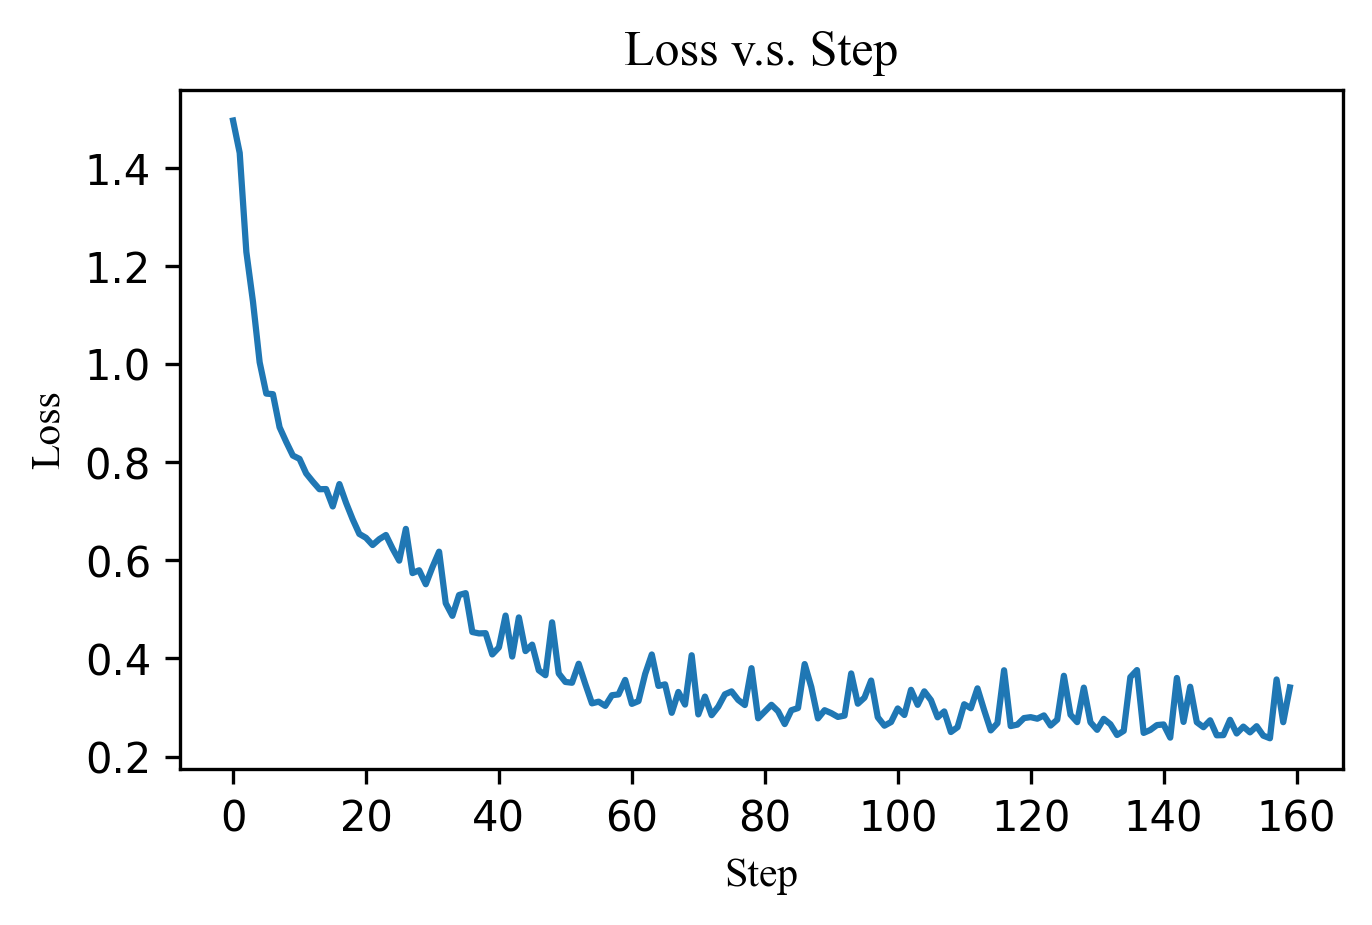

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
train_loss_data = pd.read_csv('./wandb_train_loss.csv')
train_loss = train_loss_data['divine-elevator-2 - train loss']

TNRfont = {'fontname':'Times New Roman'}
fig, ax = plt.subplots(figsize=[5,3],dpi=300)
train_loss.plot(ax=ax)
ax.set_title('Loss v.s. Step', **TNRfont)
ax.set_xlabel('Step', **TNRfont)
ax.set_ylabel('Loss', **TNRfont)
plt.show()